In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import HTML
from scipy.spatial.distance import pdist, cdist
%pylab inline

from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_df = df_tcams_nd.copy()
full_df.rename(columns={'pXC50_3D7' : 'POTENCY'}, inplace=True)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV

model_dict = {'ridge' : {'m': Ridge, 'kw': {'fit_intercept': True, 'alpha': 0.1}},
              'rcv':  {'m': RidgeCV, 'kw': {'cv': 5}},
              'rf': {'m': RandomForestRegressor, 'kw': {'n_estimators': 100, 'n_jobs': 4, 'max_depth': 10}}}

method = 'rf'
mdl = model_dict[method]['m'](**model_dict[method]['kw'])

full_df.dropna(subset=['POTENCY'], inplace=True)
fpa = np.asarray([x for x in full_df.fps.values])

In [3]:
%%time
std_files = ['/Users/oliverwatson/evartech/molport/standardn_' + str(i) for i in range(15)]

df0 = pd.read_pickle(std_files[0])

N = df0.shape[0] 
i = 0

redo = False

if redo:
    all_dists = np.asarray([])

    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
        all_dists = np.concatenate((all_dists, blk_dists))
        i += 10000
        pass
    np.save('all_dists.npy', all_dists)

all_dists = np.load('all_dists.npy')

CPU times: user 7.27 s, sys: 778 ms, total: 8.05 s
Wall time: 8.88 s


In [4]:
assert(std_files[0] == '/Users/oliverwatson/evartech/molport/standardn_0')

In [5]:
%%time

df0 = pd.read_pickle(std_files[0])

N = df0.shape[0]
i = 0
n_2 = int(fpa.shape[0]/2)
redo = False

if redo:
    all_distsN = np.asarray([])
    all_distsN2 = np.asarray([])
    
    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        idcs2 = np.random.choice(fpa.shape[0], n_2, replace=False)
        fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
        blk_dists2 = nanmin(cdist(fpr, fpa[idcs2], metric='jaccard'),axis=1)
        all_distsN = np.concatenate((all_distsN, blk_dists))
        all_distsN2 = np.concatenate((all_distsN2, blk_dists2))
        i += 10000
        pass
    np.save('all_distsN.npy', all_distsN)
    np.save('all_distsN2.npy', all_distsN2)
    pass

all_distsN = np.load('all_distsN.npy')
all_distsN2 = np.load('all_distsN2.npy')

CPU times: user 7.62 s, sys: 1.02 s, total: 8.64 s
Wall time: 9.94 s


In [6]:
%%time
redo = False

if redo:
    for (j, fn) in enumerate(std_files):
        print('Doing', j)
        all_dists_long_i = np.asarray([])
        df0 = pd.read_pickle(fn)
        N = df0.shape[0]
        i = 0
        while (i < N - 1):
            idcs = np.arange(i, min(N, i+10000))
            fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
            blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
            all_dists_long_i = np.concatenate((all_dists_long_i, blk_dists))
            i += 10000
            pass
        
        np.save('all_dists_long_' + str(j) + '.npy', all_dists_long_i)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [7]:
all_dists_long = np.load('all_dists_long.npy')

In [8]:
figsize(20, 10)

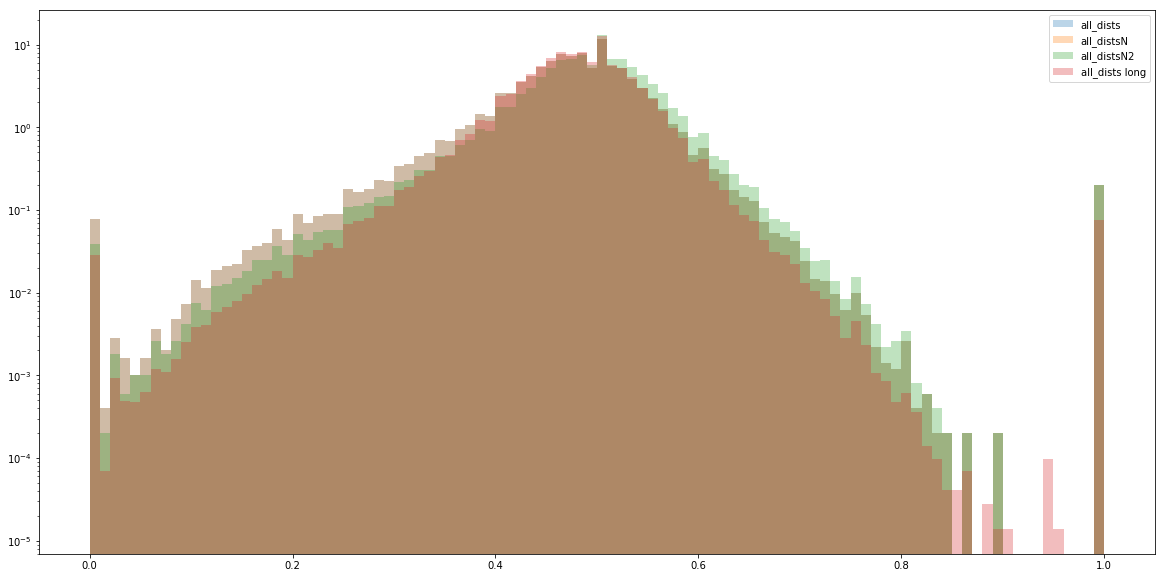

In [9]:
_ = plt.hist(all_dists, bins=100, label='all_dists', alpha=0.3, density=True)
_ = plt.hist(all_distsN, bins=100, label='all_distsN', alpha=0.3, density=True)
_ = plt.hist(all_distsN2, bins=100, label='all_distsN2', alpha=0.3, density=True)
_ = plt.hist(all_dists_long, bins=100, label='all_dists long', alpha=0.3, density=True)
_ = plt.yscale('log')
_ = legend(loc='best')

CPU times: user 59min 57s, sys: 16.9 s, total: 1h 14s
Wall time: 1h 45s


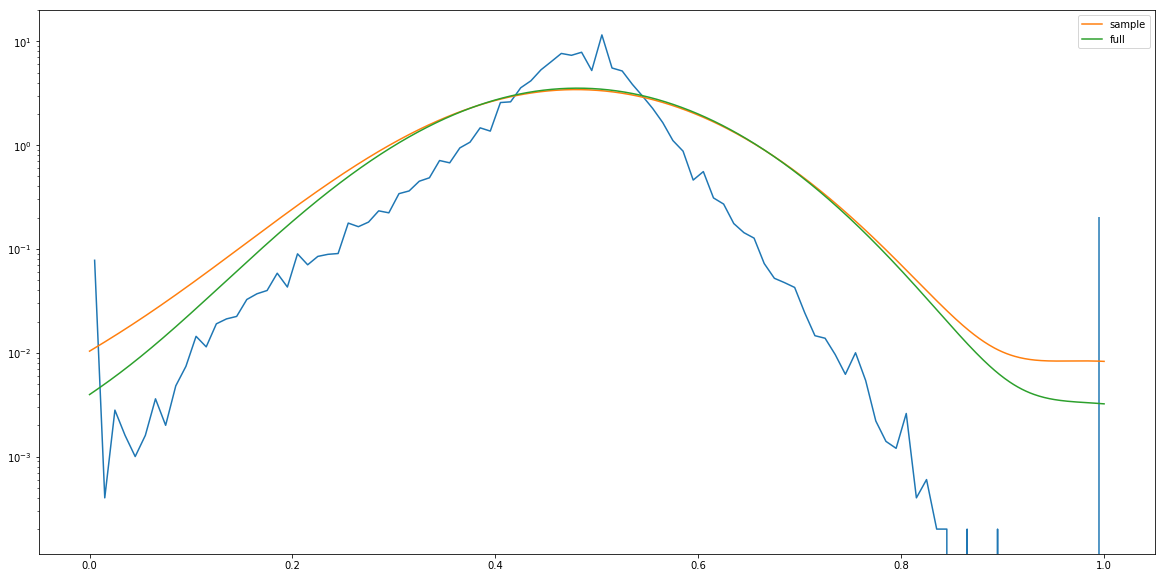

In [10]:
%%time
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(0, 1, 1000)[:, np.newaxis]
X = all_dists[~np.isnan(all_dists)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densRA = kde.score_samples(X_plot)
X = all_dists_long[~np.isnan(all_dists_long)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densRAf = kde.score_samples(X_plot)
mra_hist = np.histogram(all_dists[~np.isnan(all_dists)], density=True, bins=100)
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
plt.plot(x_axis, mra_hist[0])
plt.plot(X_plot[:,0], np.exp(log_densRA), label='sample')
plt.plot(X_plot[:,0], np.exp(log_densRAf), label='full')
_ = plt.yscale('log')
legend(loc='best')

In [11]:
fa = 13533/1985056

In [12]:
n_2 = int(fpa.shape[0]/2)
tries = 5
redo = False
if redo:
    all_AdistsN2 = np.asarray([])
    
    for i in range(tries):
        idcs2 = np.random.choice(fpa.shape[0], n_2, replace=False)
        idcs1 = np.delete(np.arange(fpa.shape[0]), idcs2)
        blk_dists2 = nanmin(cdist(fpa[idcs1], fpa[idcs2], metric='jaccard'),axis=1)
        blk_dists2p = nanmin(cdist(fpa[idcs2], fpa[idcs1], metric='jaccard'),axis=1)
        all_AdistsN2 = np.concatenate((blk_dists2, blk_dists2p, all_AdistsN2))
        #all_AdistsN2 = np.concatenate((blk_dists2, all_AdistsN2))
        pass
    np.save('all_AdistsN2_sc.npy', all_AdistsN2)
    pass
all_AdistsN2 = np.load('all_AdistsN2_sc.npy')

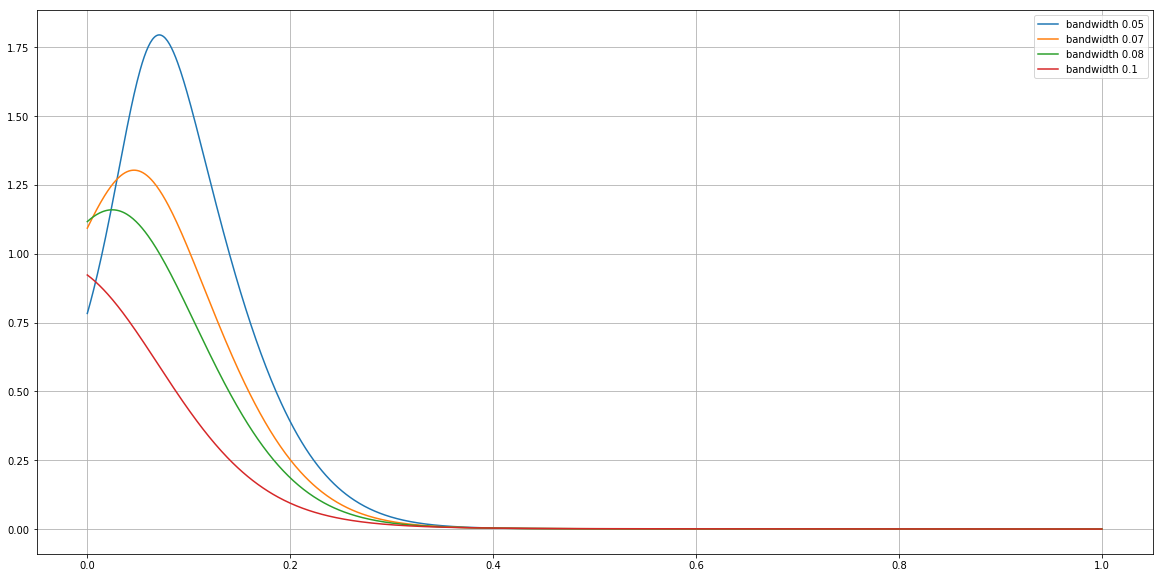

In [13]:
for bandwith in [0.05, 0.07, 0.08, 0.1]:
    X = all_distsN2[~np.isnan(all_distsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith))
grid(True)
legend(loc='best')
savefig('bandwidth.png')

In [14]:
all_AdistsN2_full = np.load('all_AdistsN2.npy')

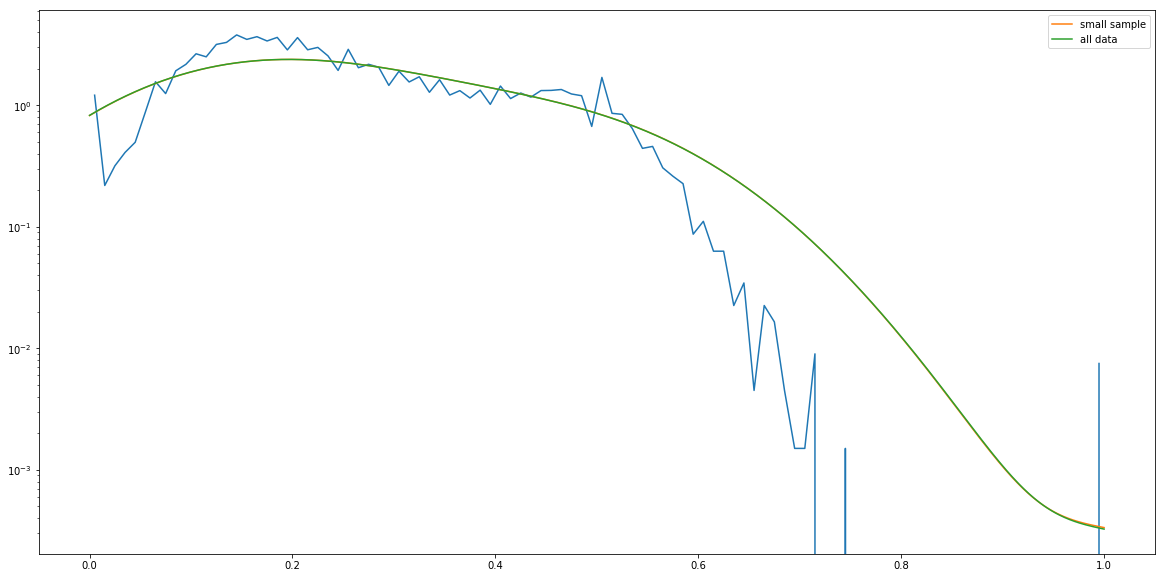

In [15]:
# Doing the correct way (2-way)
mra_hist = np.histogram(all_AdistsN2[~np.isnan(all_AdistsN2)], density=True, bins=100)
X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densAA = kde.score_samples(X_plot)
X = all_AdistsN2_full[~np.isnan(all_AdistsN2_full)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densAAf = kde.score_samples(X_plot)
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
plt.plot(x_axis, mra_hist[0])
plt.plot(X_plot[:,0], np.exp(log_densAA), label='small sample')
plt.plot(X_plot[:,0], np.exp(log_densAAf), label='all data')
_ = plt.yscale('log')
legend(loc='best')

### Stuff to do next...

- How many compounds are not in the MolPort database at all?  Plot some.

- try doing a random properly-weighted sample from the full distribution - see if that gives the correct result

- Plot random compounds from each file - see if you spot a pattern.

In [16]:
redo = False

if redo:
    all_dists_toMP = np.ones(fpa.shape[0])

    for fn in std_files:
        df0 = pd.read_pickle(fn)
        N = df0.shape[0]
        i = 0
        while (i < N - 1):
            idcs = np.arange(i, min(N, i+10000))
            fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
            blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=0)
            all_dists_toMP = np.minimum(blk_dists, all_dists_toMP)
            i += 10000
            pass
    np.save('all_dists_toMP.npy', all_dists_toMP)
else:
    all_dists_toMP = np.load('all_dists_toMP.npy')

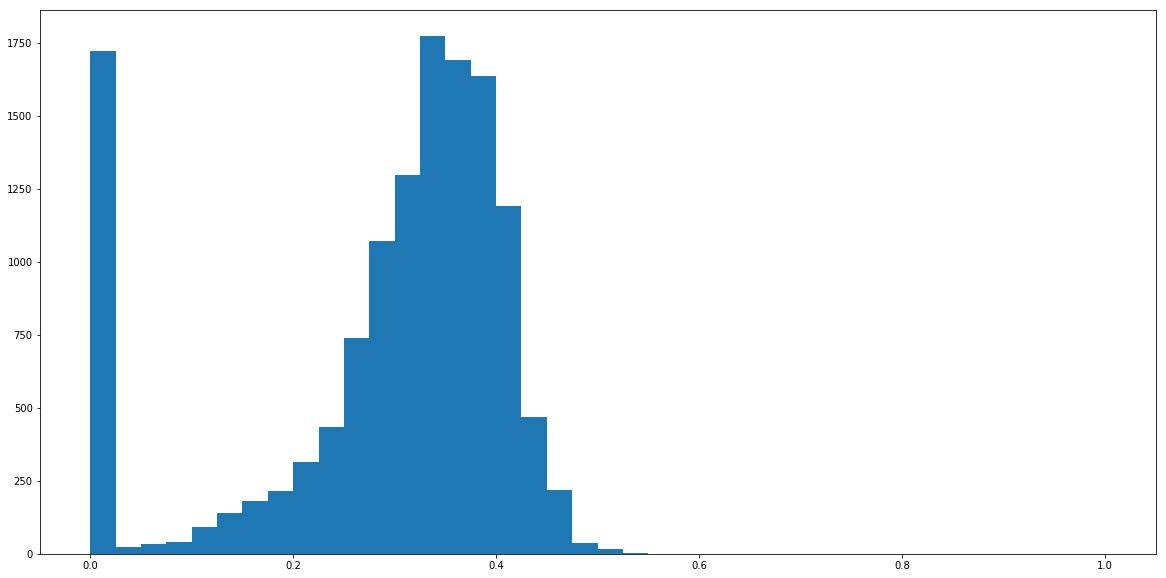

In [17]:
_ = plt.hist(all_dists_toMP, bins=40)

In [18]:
df_tcams_nd.iloc[1].name

'Brc1cc(Br)c2c(c1)C(NCCCNC1CCNc3c(Br)cc(Br)cc31)CCN2'

In [19]:
for i in range(15):
    ad = np.load('all_dists_long_' + str(i) + '.npy')
    print("File %2d - zero distance : %5d, distance < 0.1 : %5d  distance < 0.3 : %5d, points %d" % 
          (i, np.sum(ad == 0), np.sum(ad < 0.1), np.sum(ad < 0.3), len(ad)))

File  0 - zero distance :   389, distance < 0.1 :   515  distance < 0.3 :  9028, points 499939
File  1 - zero distance :   352, distance < 0.1 :   487  distance < 0.3 :  8870, points 499944
File  2 - zero distance :   305, distance < 0.1 :   401  distance < 0.3 :  5728, points 499824
File  3 - zero distance :   362, distance < 0.1 :   448  distance < 0.3 :  6509, points 499026
File  4 - zero distance :   133, distance < 0.1 :   166  distance < 0.3 :  3881, points 499396
File  5 - zero distance :   105, distance < 0.1 :   137  distance < 0.3 :  3446, points 499308
File  6 - zero distance :   157, distance < 0.1 :   221  distance < 0.3 :  5920, points 498290
File  7 - zero distance :    17, distance < 0.1 :    22  distance < 0.3 :  1825, points 499183
File  8 - zero distance :    58, distance < 0.1 :    78  distance < 0.3 :  2427, points 496725
File  9 - zero distance :    52, distance < 0.1 :    71  distance < 0.3 :  1988, points 499829
File 10 - zero distance :    25, distance < 0.1 : 

### Do a properly weighted sample from whole distribution

In [20]:
def choose_sample(distance=0.3, size=500000, debug=True):
    counts = []
    for i in range(15):
        ad = np.load('all_dists_long_' + str(i) + '.npy')
        counts.append(np.sum(ad <= distance))
        pass
    total = np.sum(counts)
    if debug:
        print(counts)
        pass
    distances = np.asarray([])
    for i in range(15):
        ad = np.load('all_dists_long_' + str(i) + '.npy')
        to_choose = int(size * counts[i]/float(total))
        if debug:
            print('Choosing', to_choose, 'from file', i)
            pass
        idcs = np.random.choice(ad.shape[0], to_choose)
        distances = np.concatenate((distances, ad[idcs]))
        pass
    return distances

[4483, 4044, 2876, 3012, 1564, 1319, 2634, 568, 909, 769, 507, 246, 135, 504, 102]
Choosing 94689 from file 0
Choosing 85417 from file 1
Choosing 60746 from file 2
Choosing 63619 from file 3
Choosing 33034 from file 4
Choosing 27859 from file 5
Choosing 55635 from file 6
Choosing 11997 from file 7
Choosing 19199 from file 8
Choosing 16242 from file 9
Choosing 10708 from file 10
Choosing 5196 from file 11
Choosing 2851 from file 12
Choosing 10645 from file 13
Choosing 2154 from file 14


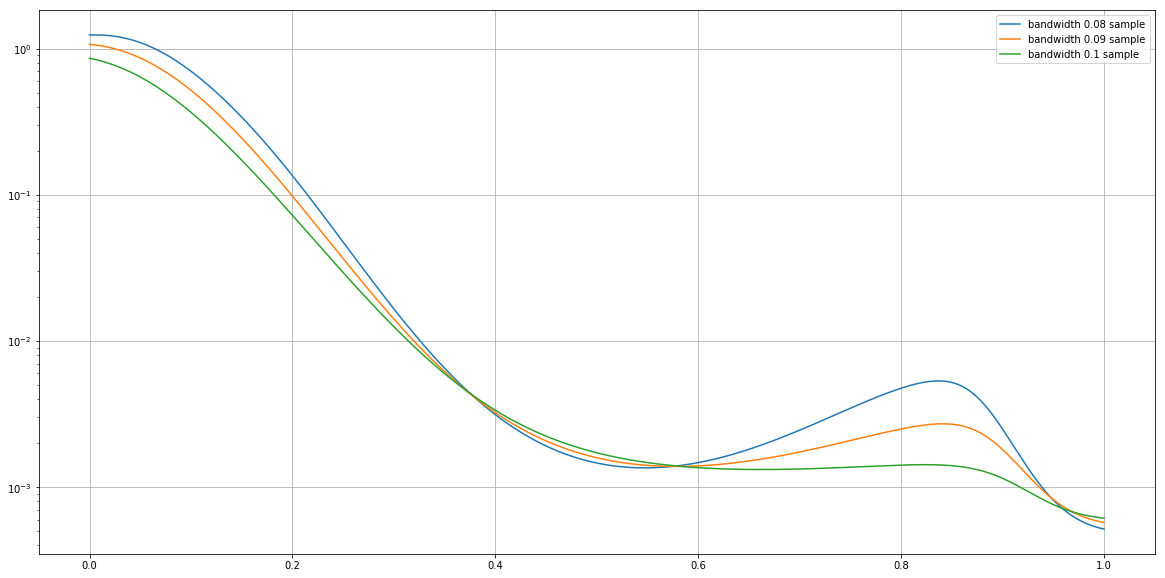

In [21]:
sample_dists = choose_sample(distance=0.25)

for bandwith in [ 0.08, 0.09, 0.1,]:
    X = sample_dists[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')
plt.yscale('log')

[499939, 499944, 499824, 499026, 499396, 499308, 498290, 499183, 496725, 499829, 499931, 499892, 499965, 499895, 239894]
Choosing 34568 from file 0
Choosing 34569 from file 1
Choosing 34560 from file 2
Choosing 34505 from file 3
Choosing 34531 from file 4
Choosing 34525 from file 5
Choosing 34454 from file 6
Choosing 34516 from file 7
Choosing 34346 from file 8
Choosing 34561 from file 9
Choosing 34568 from file 10
Choosing 34565 from file 11
Choosing 34570 from file 12
Choosing 34565 from file 13
Choosing 16587 from file 14


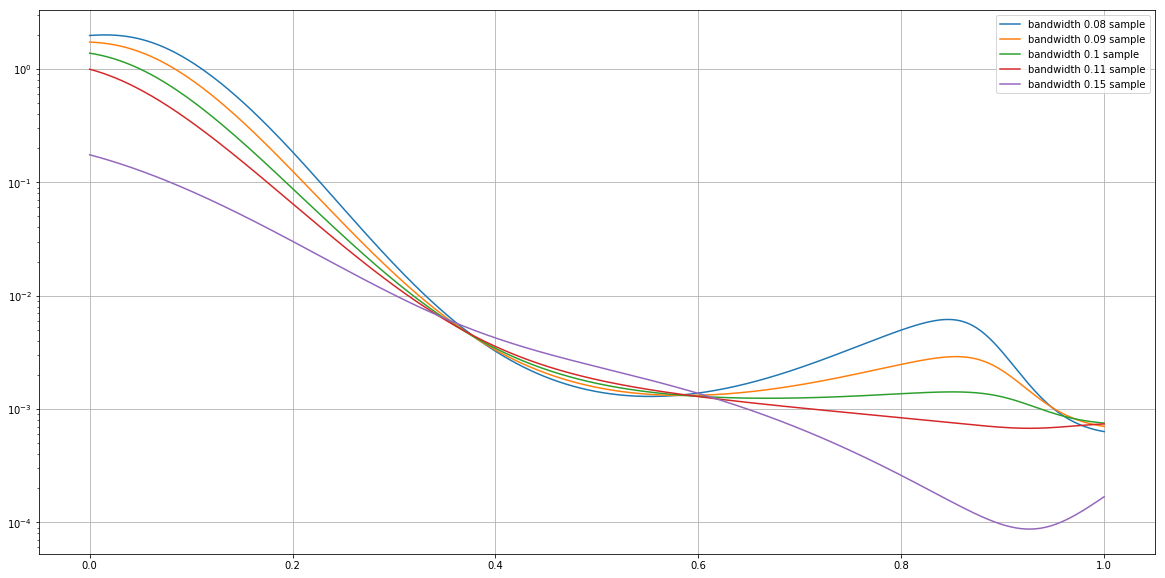

In [22]:
sample_dists = choose_sample(distance=1.0)
fa = 13533/1985056
for bandwith in [ 0.08, 0.09, 0.1, 0.11, 0.15]:
    X = sample_dists[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')
plt.yscale('log')

### Plan...

- Take a bunch of different sizes in the range [0.. 0.4]
- select 100K points according to those criteria.
- Find, by binary search, to 1 dp, the bandwidth that gives 1.0 at 0.
- Then choose various distances to see which gives 1.0 with that bandwidth.
- then choose as many points as possible with that 

In [23]:
def calc_beta(d, debug=True):
    
    upper = 0.15
    lower = 0.05
    sample_dists = choose_sample(distance=d, size=100000, debug=False)
    
    while (upper - lower) > 0.005:

        mid = (upper + lower)/2
        
        kdeM = KernelDensity(kernel='gaussian', bandwidth=mid).fit(sample_dists[:,None])
        log_densRAM = kdeM.score_samples(X_plot[0,None])
        f0M = fa * np.exp(log_densAA[0] - log_densRAM[0])

        if debug:
            print(f0M)
        if f0M > 1:
            if debug:
                print('Setting lower to', mid)
            lower = mid
        else:
            if debug:
                print('Setting upper to', mid)
            upper = mid
    
    return mid
            


In [24]:
def estimate_f0(sample_dists, bandwidth):
    kdem = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sample_dists[:,None])
    log_densRAM = kdem.score_samples(X_plot[0,None])
    f0M = fa * np.exp(log_densAA[0] - log_densRAM[0])
    return f0M

In [25]:
bdwiths = []
for dist in np.arange(0, 0.5, 0.05):
    for j in range(20):
        bdwiths.append(calc_beta(dist, debug=False))

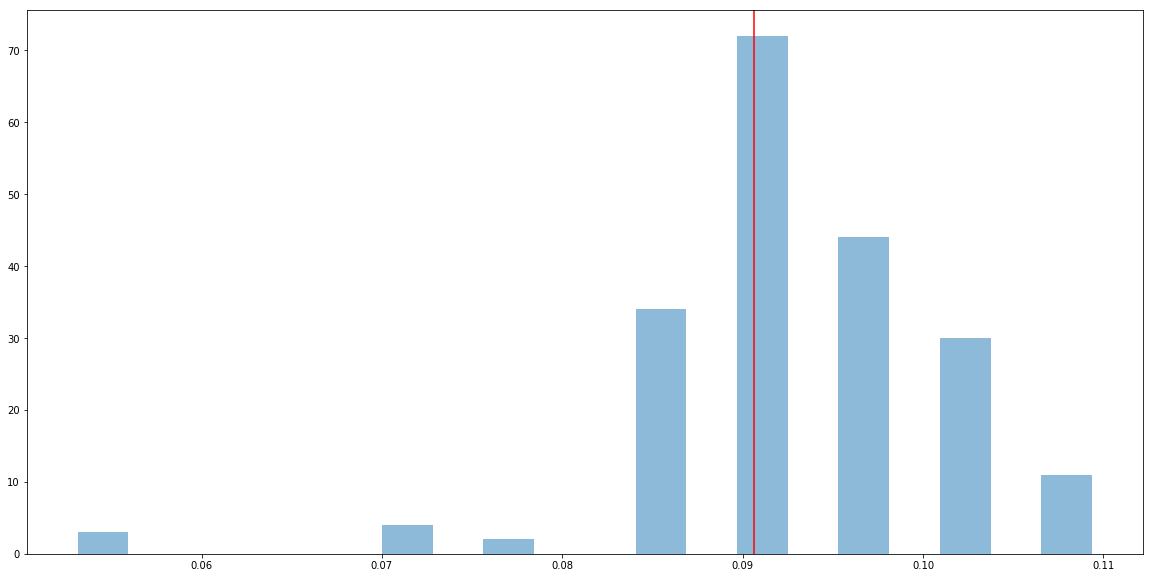

In [26]:
v = np.median(bdwiths)
_ = plt.hist(bdwiths, alpha=0.5, bins=20); plt.axvline(x=v, color='red')

In [27]:
np.median(bdwiths)

0.090625000000000011

In [28]:
ds = np.arange(0, 0.6, 0.05)
means = []
stds = []
for d in ds:
    vals = [estimate_f0(choose_sample(distance=d, debug=False, size=100000), bandwidth=np.median(bdwiths)) 
            for i in range(10)]
    means.append(np.mean(vals))
    stds.append(np.std(vals)/np.sqrt(10))
    pass

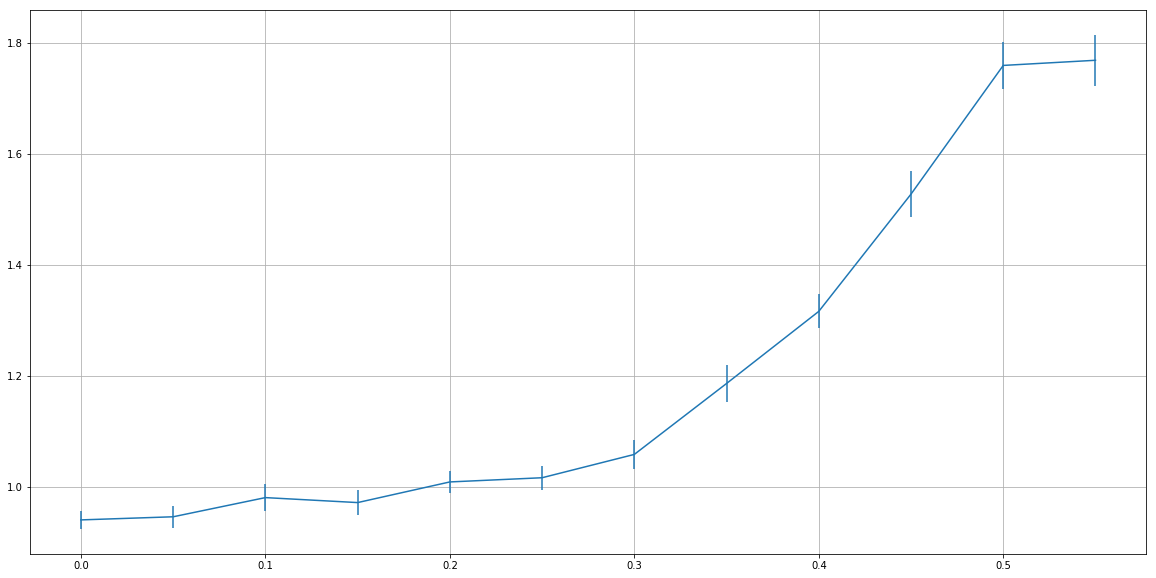

In [29]:
plt.errorbar(ds, means, yerr=stds)
grid(True)

[973, 818, 683, 730, 286, 253, 467, 55, 153, 135, 82, 33, 27, 110, 17]
Choosing 403566 from file 0
Choosing 339278 from file 1
Choosing 283284 from file 2
Choosing 302778 from file 3
Choosing 118622 from file 4
Choosing 104935 from file 5
Choosing 193695 from file 6
Choosing 22812 from file 7
Choosing 63459 from file 8
Choosing 55993 from file 9
Choosing 34010 from file 10
Choosing 13687 from file 11
Choosing 11198 from file 12
Choosing 45624 from file 13
Choosing 7051 from file 14


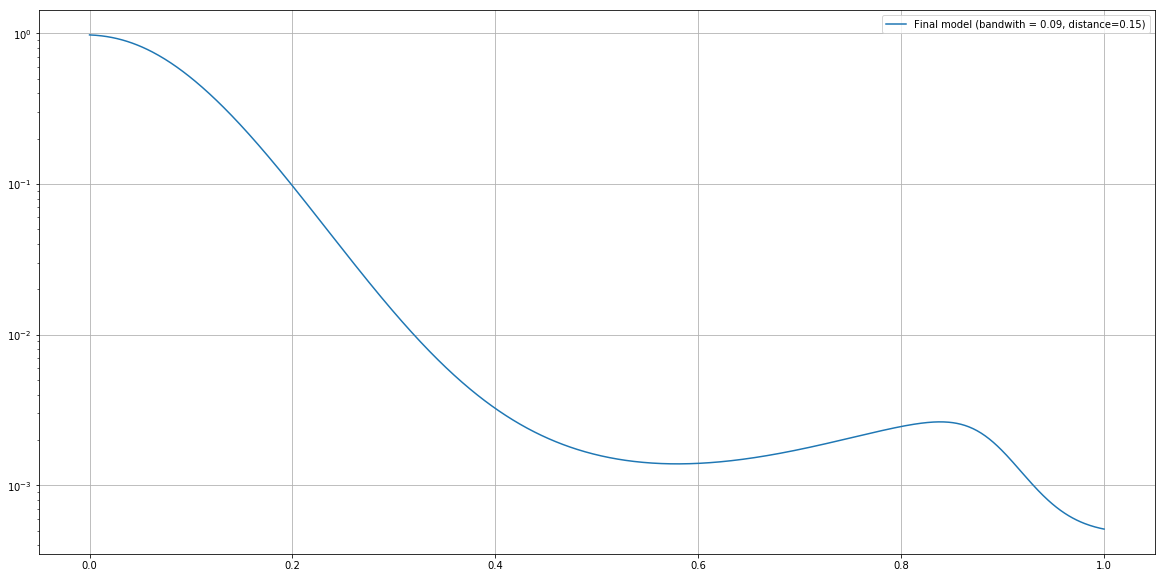

In [30]:
np.random.seed(42)
big_sample = choose_sample(distance=0.15, size=2000000)
kdeF = KernelDensity(kernel='gaussian', bandwidth=0.09).fit(big_sample[:,np.newaxis])
log_densRAF = kdeF.score_samples(X_plot)
plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAF), label='Final model (bandwith = 0.09, distance=0.15)')
grid(True)
legend(loc='best')
plt.yscale('log')

In [31]:
# OK - final choice:  bandwidth = 0.09, d = 0.15

[973, 818, 683, 730, 286, 253, 467, 55, 153, 135, 82, 33, 27, 110, 17]
Choosing 100891 from file 0
Choosing 84819 from file 1
Choosing 70821 from file 2
Choosing 75694 from file 3
Choosing 29655 from file 4
Choosing 26233 from file 5
Choosing 48423 from file 6
Choosing 5703 from file 7
Choosing 15864 from file 8
Choosing 13998 from file 9
Choosing 8502 from file 10
Choosing 3421 from file 11
Choosing 2799 from file 12
Choosing 11406 from file 13
Choosing 1762 from file 14


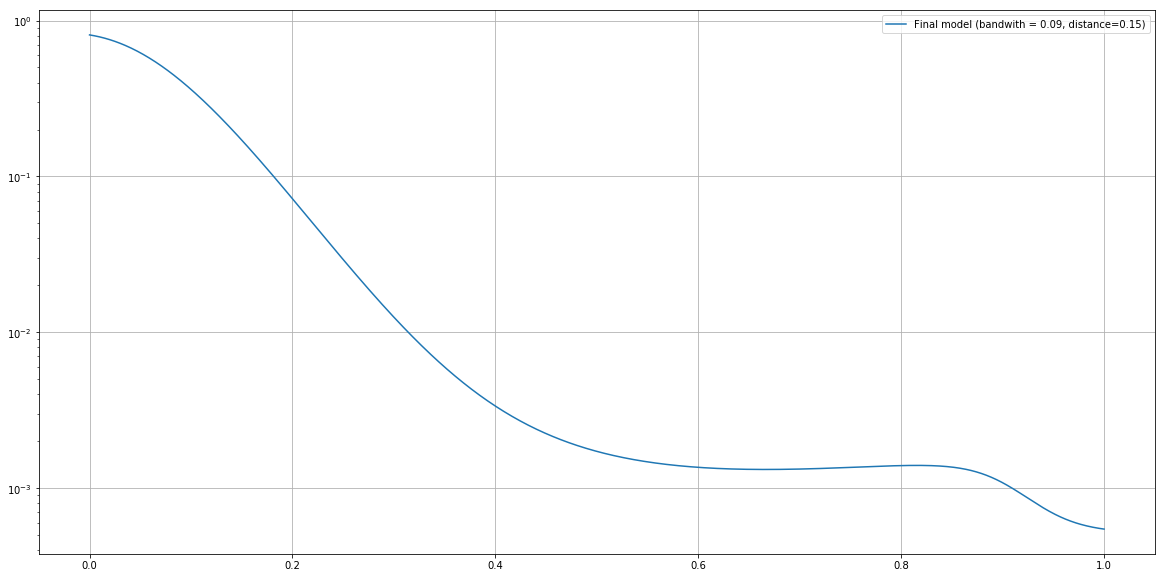

In [32]:
np.random.seed(42)
big_sample = choose_sample(distance=0.15, size=500000)
kdeF = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(big_sample[:,np.newaxis])
log_densRAF = kdeF.score_samples(X_plot)
plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAF), label='Final model (bandwith = 0.09, distance=0.15)')
grid(True)
legend(loc='best')
plt.yscale('log')

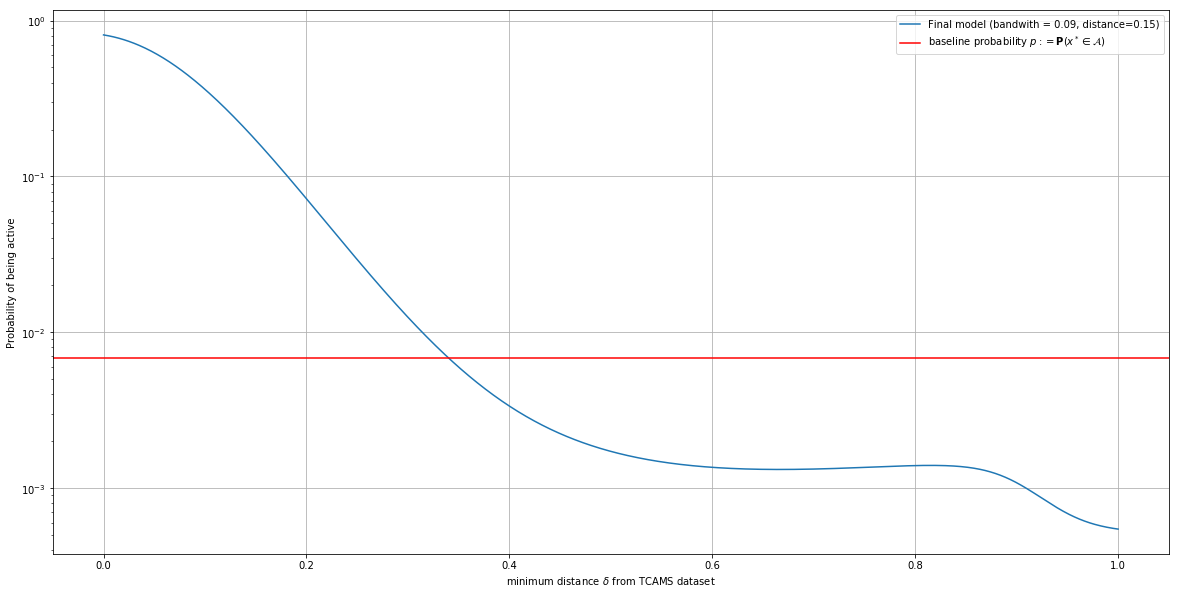

In [33]:
np.random.seed(42)
plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAF), label='Final model (bandwith = 0.09, distance=0.15)')
plt.axhline(y=fa, color='red', label=r'baseline probability $p := \mathbf{P}(x^*\in \mathcal{A})$')
grid(True)
legend(loc='best')
plt.ylabel('Probability of being active')
plt.xlabel(r'minimum distance $\delta$ from TCAMS dataset')
plt.yscale('log')
savefig('figures/frac_active.png')

## Spline fitting for the extrapolation

In [34]:
fc_rf_hdr = {}
fc_lr_hdr = {}
#ctr_hdr = {}  # this tells you the mean distance...

def rank(x):
    return np.argsort(np.argsort(x))/(len(x) + 0.) - 0.5

bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]

# stats.run_big_fit(full_df.dropna(subset=['POTENCY']))

#joblib.dump(fc_rf_hdr, 'modelling/rf_fc_results')
#joblib.dump(fc_lr_hdr, 'modelling/rdg_fc_results')
#joblib.dump(ctr_hdr, 'modelling/ctr_results')
fc_rf_hdr = joblib.load('modelling/rf_fc_results')
fc_lr_hdr = joblib.load('modelling/rdg_fc_results')
#ctr_hdr = joblib.load('modelling/ctr_results')


#result_hdr = {'rf' : [], 'rdg' : [], 'rfrk' : [], 'rdgrk' : [], 
#             'rfb' : [], 'rdgb' : [], 'rfrkb' : [], 'rdgrkb' : [], 
#             }#
#
#for i in range(len(bins)):
#    rf_beta, rf_r2 = stats.regress(full_df.POTENCY.values, [fc_rf_hdr[i],], do_print=False, one=True)
#    rdg_beta, rdg_r2 = stats.regress(full_df.POTENCY.values, [fc_lr_hdr[i],], do_print=False, one=True)
#    rfr_beta, rfr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_rf_hdr[i]),], 
#                                     do_print=False)
#    rdgr_beta, rdgr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_lr_hdr[i]),], 
#                                       do_print=False)   
#    
#    result_hdr['rf'].append(rf_r2)
#    result_hdr['rfb'].append(rf_beta[0])
#    result_hdr['rdg'].append(rdg_r2)
#    result_hdr['rdgb'].append(rdg_beta[0])
#    result_hdr['rfrk'].append(rfr_r2)
#    result_hdr['rfrkb'].append(rfr_beta[0])
#    result_hdr['rdgrk'].append(rdgr_r2)
#    result_hdr['rdgrkb'].append(rdgr_beta[0])
       
result_hdr = joblib.load('results/summary_results_tcnd')

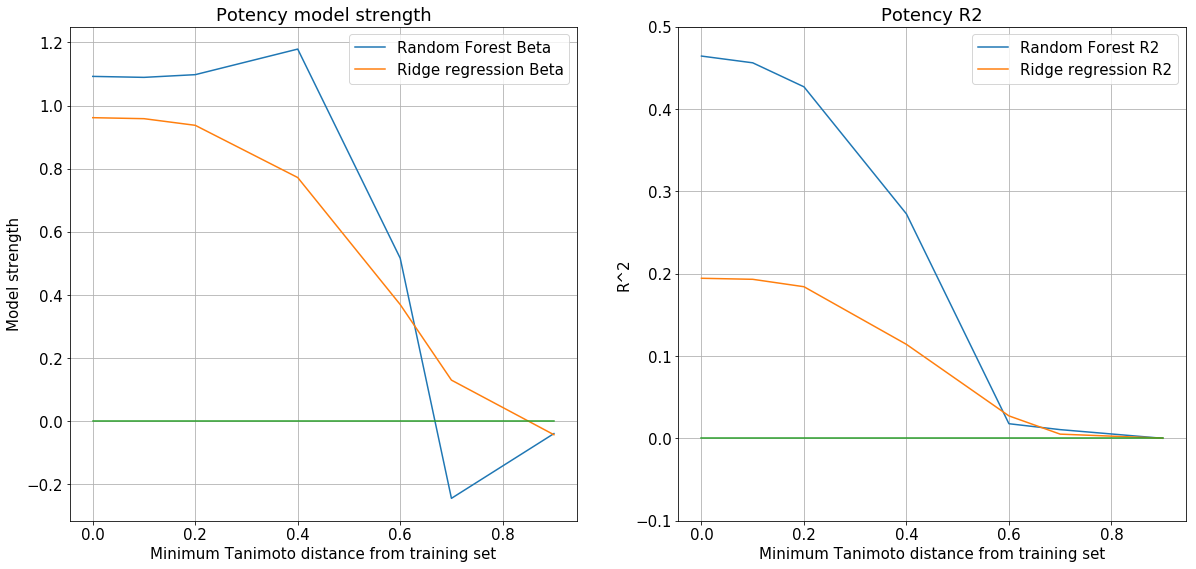

In [35]:
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7,  0.9]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Potency model strength')
plt.subplot(222)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.5))
plt.grid(True); plt.legend(loc='best')
_ = plt.title('Potency R2')

In [36]:
import scipy.interpolate as interpolate

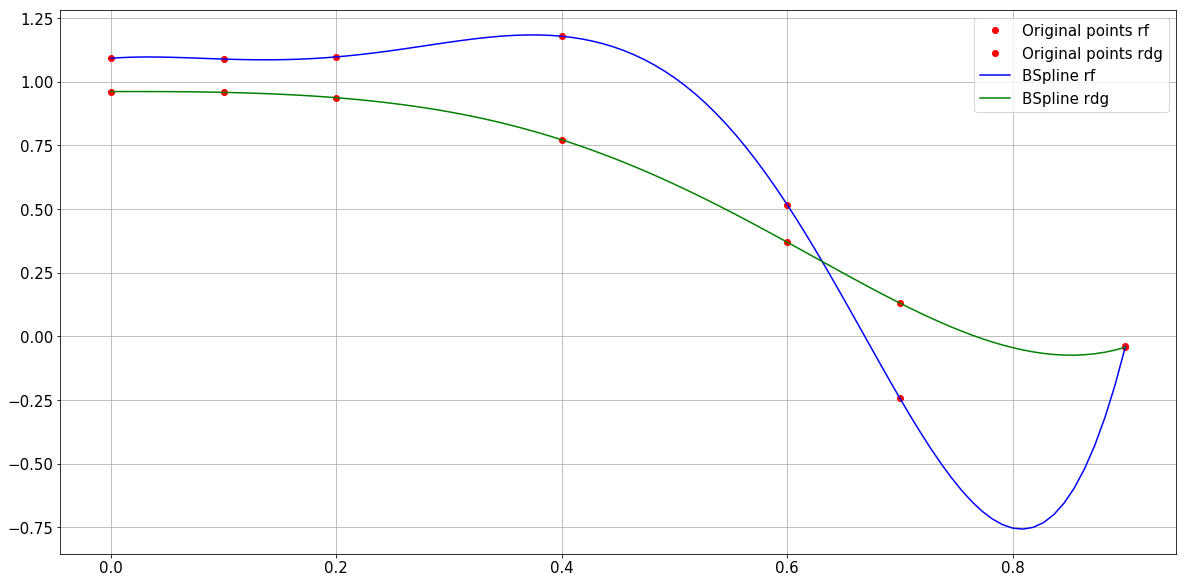

In [37]:
x = np.asarray(bins)
y = np.asarray(result_hdr['rfb'])
y2 = np.asarray(result_hdr['rdgb'])

t, c, k = interpolate.splrep(x, y, s=0, k=4)
t2, c2, k2 = interpolate.splrep(x, y2, s=0, k=4)


N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
rfb_spline = interpolate.BSpline(t, c, k, extrapolate=True)
rdg_spline = interpolate.BSpline(t2, c2, k2, extrapolate=True)

plt.plot(x, y, 'ro', label='Original points rf')
plt.plot(x, y2, 'ro', label='Original points rdg')
plt.plot(xx, rfb_spline(xx), 'b', label='BSpline rf')
plt.plot(xx, rdg_spline(xx), 'g', label='BSpline rdg')
#plt.plot(np.linspace(0, 1), interpolate.spline(bins, result_hdr['rfb'], np.linspace(0, 1)))
plt.grid()
plt.legend(loc='best')
_ = plt.show()

In [40]:
xx

array([ 0.        ,  0.00909091,  0.01818182,  0.02727273,  0.03636364,
        0.04545455,  0.05454545,  0.06363636,  0.07272727,  0.08181818,
        0.09090909,  0.1       ,  0.10909091,  0.11818182,  0.12727273,
        0.13636364,  0.14545455,  0.15454545,  0.16363636,  0.17272727,
        0.18181818,  0.19090909,  0.2       ,  0.20909091,  0.21818182,
        0.22727273,  0.23636364,  0.24545455,  0.25454545,  0.26363636,
        0.27272727,  0.28181818,  0.29090909,  0.3       ,  0.30909091,
        0.31818182,  0.32727273,  0.33636364,  0.34545455,  0.35454545,
        0.36363636,  0.37272727,  0.38181818,  0.39090909,  0.4       ,
        0.40909091,  0.41818182,  0.42727273,  0.43636364,  0.44545455,
        0.45454545,  0.46363636,  0.47272727,  0.48181818,  0.49090909,
        0.5       ,  0.50909091,  0.51818182,  0.52727273,  0.53636364,
        0.54545455,  0.55454545,  0.56363636,  0.57272727,  0.58181818,
        0.59090909,  0.6       ,  0.60909091,  0.61818182,  0.62

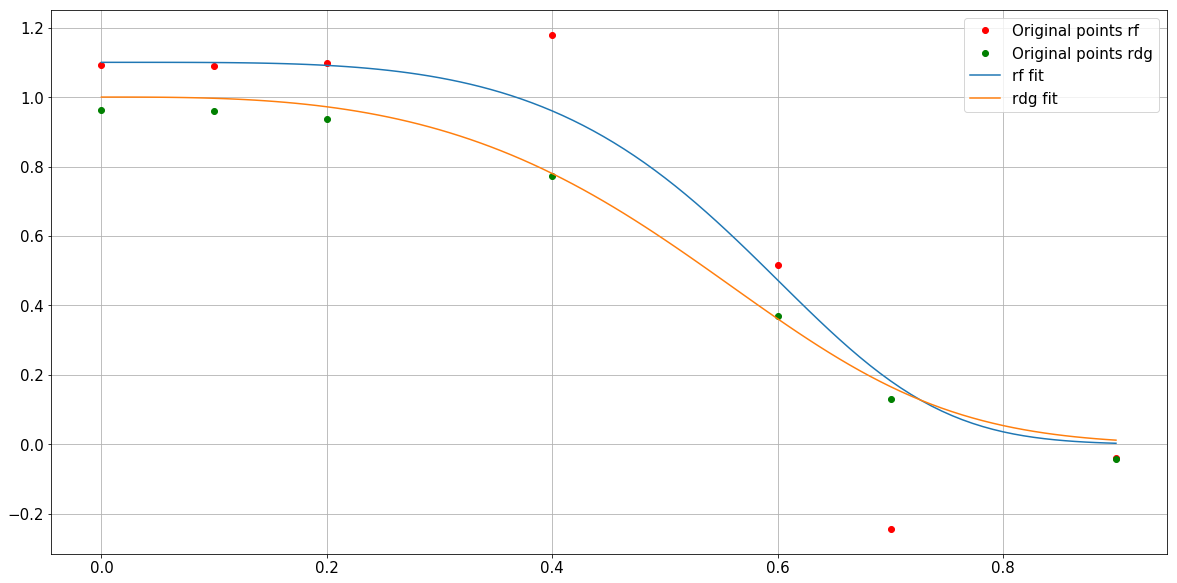

In [52]:
x = np.asarray(bins)
y = np.asarray(result_hdr['rfb'])
y2 = np.asarray(result_hdr['rdgb'])

N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)


plt.plot(x, y, 'ro', label='Original points rf')
plt.plot(x, y2, 'go', label='Original points rdg')
plt.plot(xx,  2.2/(1+np.exp(10*xx**4)), label='rf fit')
plt.plot(xx,  2/(1+np.exp(7*xx**3)), label='rdg fit')
#plt.plot(xx, rfb_spline(xx), 'b', label='BSpline rf')
#plt.plot(xx, rdg_spline(xx), 'g', label='BSpline rdg')
#plt.plot(np.linspace(0, 1), interpolate.spline(bins, result_hdr['rfb'], np.linspace(0, 1)))
plt.grid()
plt.legend(loc='best')
_ = plt.show()

In [53]:
result_hdr = joblib.load('results/summary_results_tcnd')
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]
inactive_level = 3.5
active_level = np.mean(full_df.POTENCY.values)
rf_beta = partial(np.interp, xp=np.linspace(0, 1), fp=rfb_spline(np.linspace(0, 1)))
rdg_beta = partial(np.interp, xp=np.linspace(0, 1), fp=rdg_spline(np.linspace(0, 1)))

In [54]:
rf_beta = partial(np.interp, xp=np.linspace(0, 1), fp=2.2/(1+np.exp(10*(np.linspace(0, 1)**4))))
rdg_beta = partial(np.interp, xp=np.linspace(0, 1), fp=2/(1+np.exp(7*(np.linspace(0, 1)**3))))

In [55]:
frac_active = partial(np.interp, xp=X_plot[:,0], fp=(fa * np.exp(log_densAA - log_densRAF)).clip(0, 1))

In [56]:
from malaria import mp_utils, stats

full_models = stats.fit_models(full_df, full_df)

full_models['rfb'] = rf_beta
full_models['ridgeb'] = rdg_beta
full_models['frac_act'] = frac_active
full_models['inactive_level'] = inactive_level
full_models['active_level'] = active_level

In [57]:
def calc_sigma(distance, ia=inactive_level):
    
    fa = frac_active(distance)
    act_sigma = 0.27 + 0.33 * distance
    
    rs = active_level - ia
    
    e_x2 = fa * (rs*rs + act_sigma * act_sigma)
    ex_2 = (fa * rs)**2
    return np.sqrt(e_x2 - ex_2)

In [58]:
gd = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6) & (df_tcams_nd['PCT_INHIB_HEPG2'] <= 5)]
# We're going to use the compounds with values < 7.5 for fitting (see Bioinformatics paper)
df_fit = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] <= 7.5)]
# potency random forest model
# set seed so replicable
np.random.seed(42)
pot_model = model_dict['rf']['m'](**model_dict['rf']['kw']).fit(
    np.asarray([fp for fp in df_fit.fps.values]), df_fit.pXC50_3D7.values)


In [59]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists = np.min(cdist(np.asarray([fp for fp in gd.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

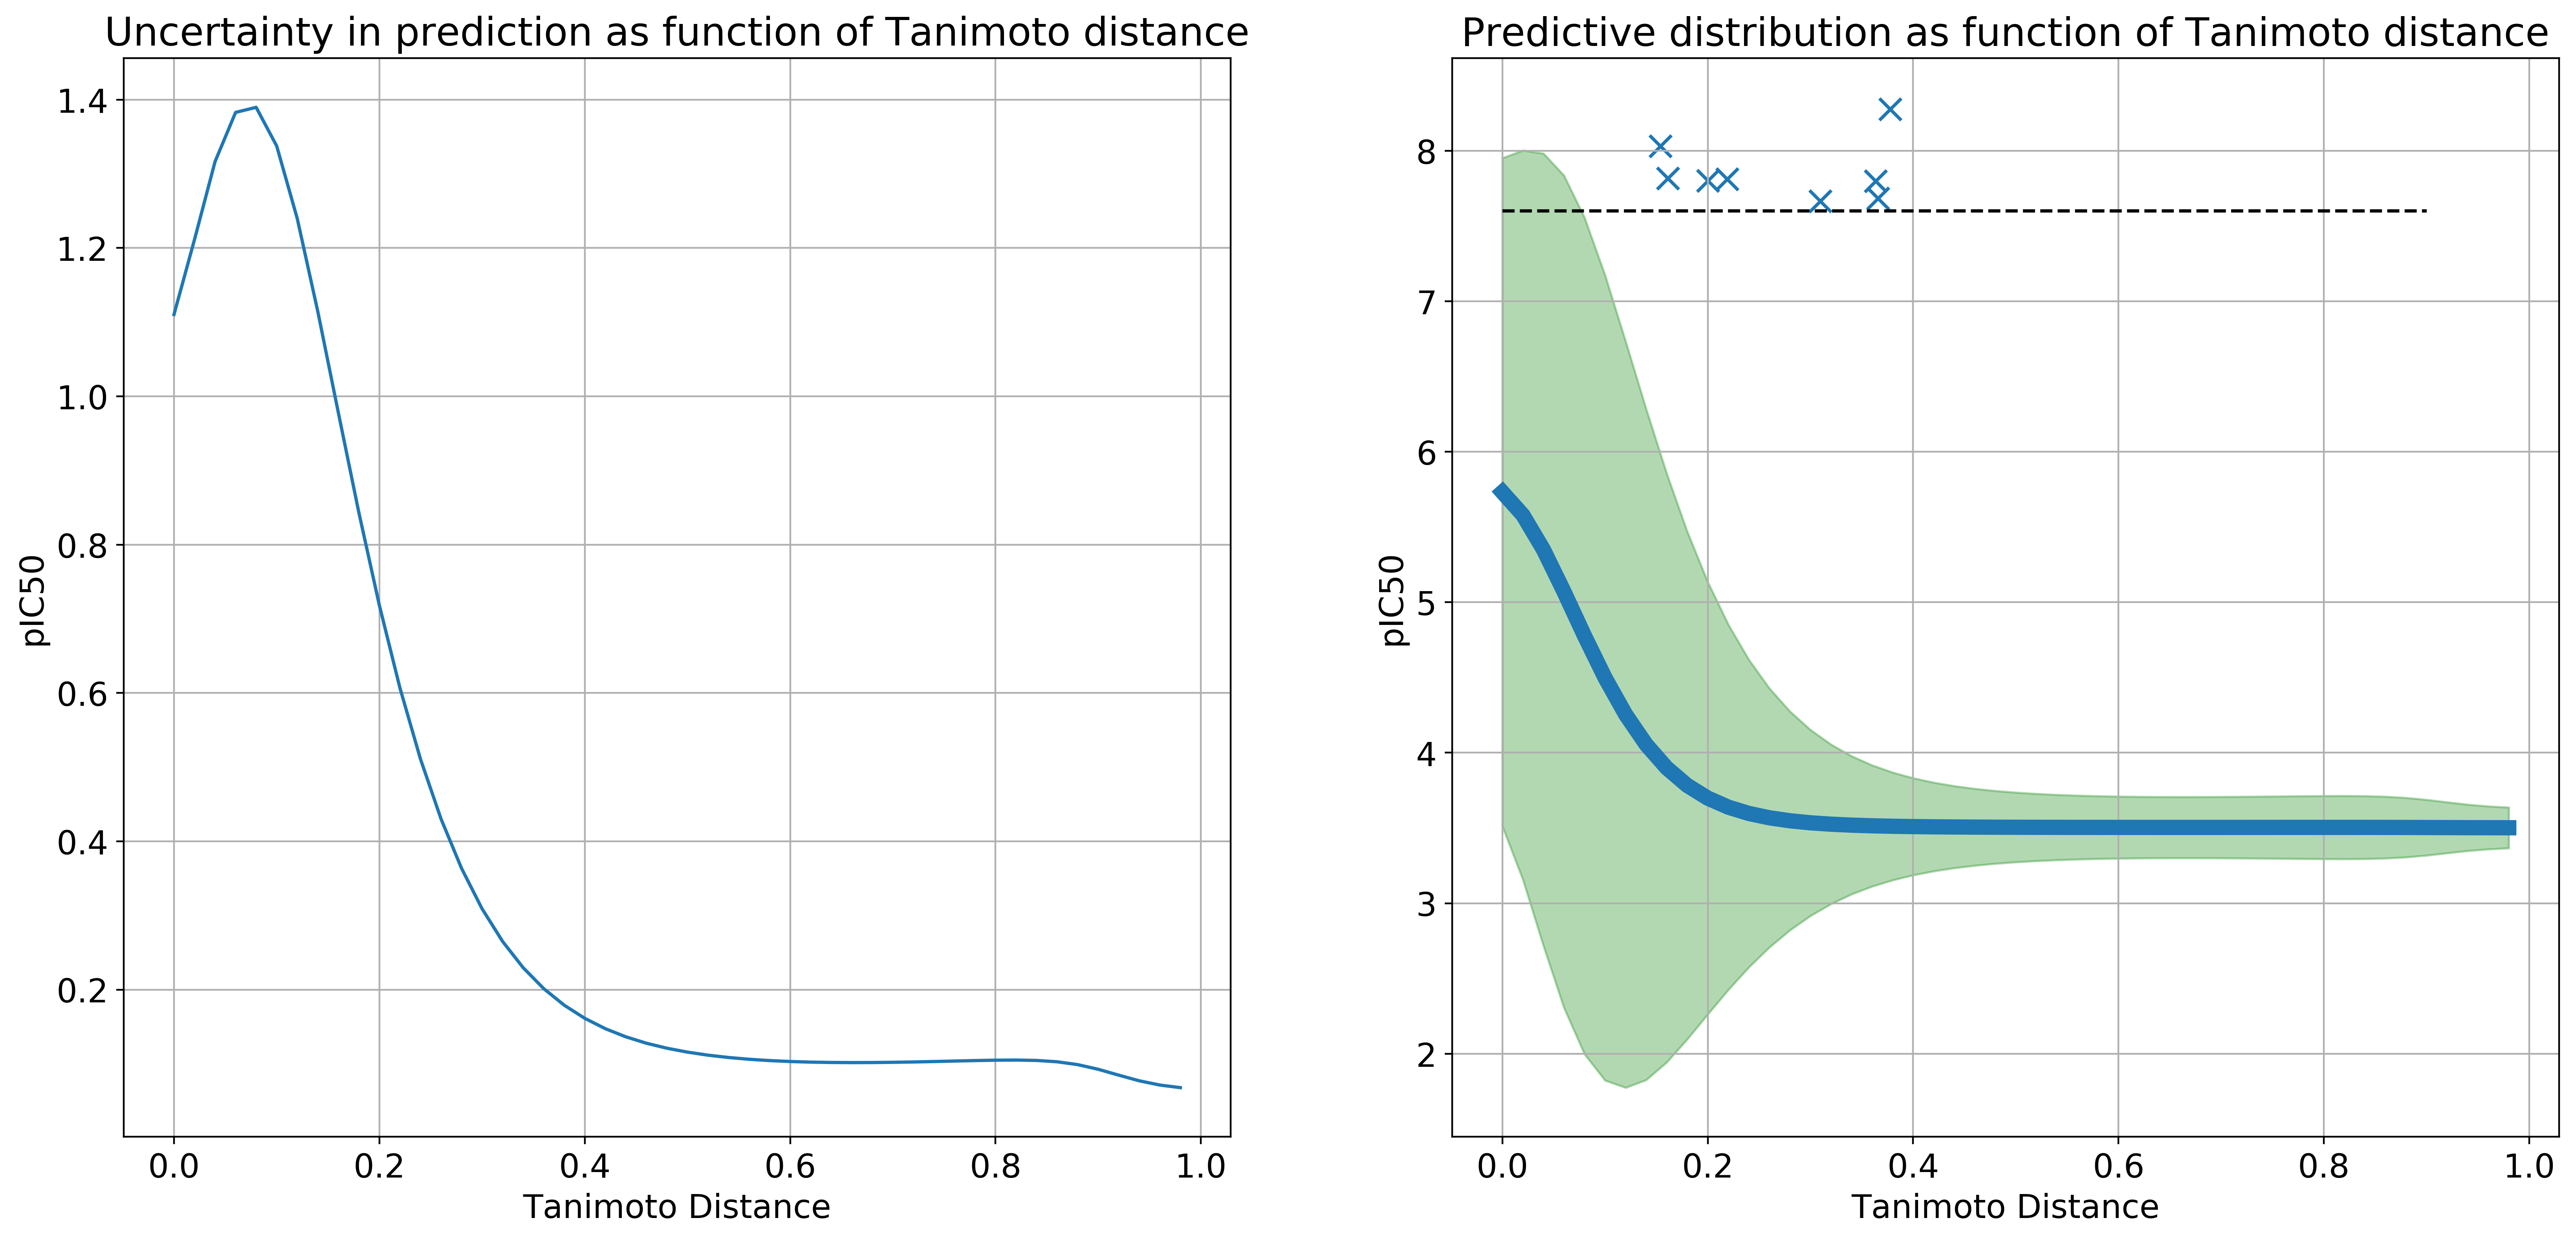

In [60]:
xv = np.arange(50)/50
siga = np.vectorize(calc_sigma)(xv)

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(221)
plt.plot(xv, siga, label='Standard Deviation (uncertainty in prediction)'); 
plt.xlabel('Tanimoto Distance')
plt.ylabel('pIC50')
plt.grid(True)
plt.title('Uncertainty in prediction as function of Tanimoto distance')
plt.subplot(222)
plt.grid(True)
plt.xlabel('Tanimoto Distance')
yv = (1-frac_active(xv)) * inactive_level + frac_active(xv) * active_level
plt.fill_between(xv, yv - 2*siga, yv + 2*siga, color='g', alpha=0.3, 
                 label='Predictive distribution approximation (95%)')
plt.plot(xv, yv, linewidth=7.0)
_ = plt.hlines(7.6, 0, 0.9, linestyles='--', label='Threshold level in our test')
_ = plt.title('Predictive distribution as function of Tanimoto distance')
plt.scatter(gd_dists, gd.pXC50_3D7.values, marker='x', s=100, label='Location of target compounds')
_= plt.ylabel('pIC50')

In [61]:
gd_fps = np.asarray([fp for fp in gd.fps.values])
gd_active_potency = pot_model.predict(gd_fps)
gd_frac_active = full_models['frac_act'](gd_dists)
gd_rf_beta = full_models['rfb'](gd_dists)
gd_predicted_potency = gd_frac_active * (gd_rf_beta * gd_active_potency + (1-gd_rf_beta)*active_level) +\
    (1-gd_frac_active)*inactive_level

In [62]:
def run_experiment2(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdpp=gd_predicted_potency, gdd=gd_dists):
    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    uncertainties = np.vectorize(calc_sigma)(distances)
    
    log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:]

In [63]:
def prob_random(n, A=8, T=20):
    x = 1
    num = n - A
    den = n
    for i in range(T):
        x *= num/den
        num -= 1
        den -= 1
    return 1-x

In [64]:
mp1 = pd.read_pickle('test_df')

In [65]:
import scipy

In [66]:
mp_fps = np.asarray([fp for fp in mp1.fps.values])

mp_active_potency = pot_model.predict(mp_fps)
mp_frac_active = full_models['frac_act'](mp1.min_dist.values)
mp_rf_beta = full_models['rfb'](mp1.min_dist.values)
molport_predicted_potency = mp_frac_active * (mp_rf_beta * mp_active_potency + (1-mp_rf_beta)*active_level) +\
    (1-mp_frac_active)*inactive_level
molport_predicted_potency[np.isnan(molport_predicted_potency)] = 0.

In [67]:
def run_experiment0(num_choice=100*1000, to_choose=20,  A=8, gdpp=gd_active_potency):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_active_potency[:num_choice], gdpp))
    
    x = sum(np.argsort(potency)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(potency)[-to_choose:]

In [68]:
def run_experiment(num_choice=100*1000, to_choose=20,  A=8, gdpp=gd_predicted_potency):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    x = sum(np.argsort(potency)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(potency)[-to_choose:]

In [69]:
_ = run_experiment(30*1000)

Probability of success if random 0.00532
Failed


In [70]:
_ = run_experiment(20*1000)

Probability of success if random 0.00797
Succeeded: 2 found


In [71]:
_ = run_experiment()

Probability of success if random 0.00160
Failed


In [72]:
_ = run_experiment2()

Probability of success if random 0.00160
Failed


In [73]:
def calc_sigma_active(distance):

    act_sigma = 0.27 + 0.33 * distance    
    return act_sigma

In [74]:
def run_experiment3(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdap=gd_active_potency, gdd=gd_dists):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((mp_active_potency[:num_choice], gdap))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    au = np.vectorize(calc_sigma_active)(distances)
    
    #log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    log_lik = np.log(frac_active(distances)) + scipy.stats.norm.logcdf((potency-target)/au)
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:], log_lik[np.argsort(log_lik)[-to_choose:]]

In [75]:
_ = run_experiment3()

Probability of success if random 0.00160
Succeeded: 2 found


In [76]:
_ = run_experiment3(200*1000)

Probability of success if random 0.00080
Succeeded: 2 found


In [77]:
_ = run_experiment3(480*1000)

Probability of success if random 0.00033
Succeeded: 2 found


In [78]:
faa = frac_active(np.arange(0, 1, 0.01))
act_sigmas = calc_sigma_active(np.arange(0, 1, 0.01))
one_pct_line = np.zeros_like(faa)
one_pct_line[faa <= 0.01] = inactive_level
one_pct_line[faa > 0.01] = (active_level + act_sigmas * scipy.stats.norm.ppf(faa).clip(-4,4))[faa > 0.01]

In [79]:
def get_contour_ll_line(target=7.6, start_point=6.5):
    """
    Gets the log-likelihood as a function of distance (log probability of a compound at distance
    d from the starting point having activity >= target).
    """
    d = np.arange(0, 1, 0.01)
    betas = full_models['rfb'](d)
    active_means = betas * start_point + (1 - betas) * active_level
    return np.log(frac_active(d)) +\
        scipy.stats.norm.logcdf((active_means-target)/np.vectorize(calc_sigma_active)(d))

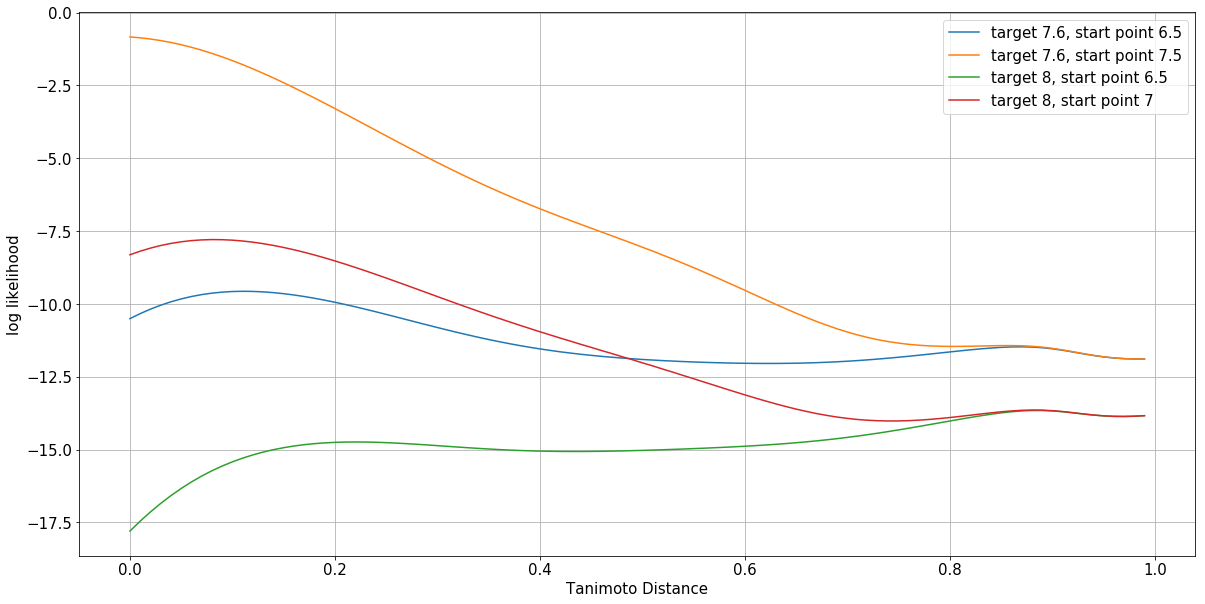

In [133]:
d = np.arange(0, 1, 0.01)
plot(d, get_contour_ll_line(), label='target 7.6, start point 6.5')
plot(d, get_contour_ll_line(start_point=7.5), label='target 7.6, start point 7.5')
plot(d, get_contour_ll_line(target=8), label='target 8, start point 6.5')
plot(d, get_contour_ll_line(target=8, start_point=7), label='target 8, start point 7')
ylabel('log likelihood')
xlabel('Tanimoto Distance')
legend(loc='best')
savefig("figures/ll_contour_lines.png")
grid(True)

In [106]:
import os
def get_min_dists(file_choice, level_fit):
    fn = 'mp_fit_dists_' + str(file_choice) + '_' + str(level_fit) + '.npy'
    if os.path.exists(fn):
        return np.load(fn)
        
    raise Exception
    min_dists = np.asarray([])
    N = mp.shape[0]
    fpr = np.asarray([x for x in fit.fps.values])
    i = 0
    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        fpa = np.asarray([x for x in mp.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpa, fpr, metric='jaccard'),axis=1)
        min_dists = np.concatenate((min_dists, blk_dists))
        i += 10000
    return min_dists

In [142]:
def run_experiment_full(num_choice=500*1000, to_choose=20, method='rf', file_choice=0, silent=True,
                        level_predict=7.6, level_fit=7.5, test_method='james', debug=False):
    
        
    methods = ['basic', # Just fit basic model and use that
               'beliefed_acc',  # Belief basic model predictions towards mean accuracy (on actives)
               'beliefed_fa'  # in addition belief down with frac accuracy
               'james'  # Use sigma
              ]
    
    good = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= level_predict)]
    df_fit = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] <= level_fit)]

    np.random.seed(42)
    
    act_model = model_dict[method]['m'](**model_dict[method]['kw']).fit(
                np.asarray([fp for fp in df_fit.fps.values]), df_fit.pXC50_3D7.values)
    
    # We need the minumum distances (for our model) for the good compounds from the fit dataset...
    good_dists = np.min(cdist(np.asarray([fp for fp in good.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)
    
    good_fps = np.asarray([fp for fp in good.fps.values])
    good_basic_potency = act_model.predict(good_fps)
    
    good_beta = full_models[method + 'b'](good_dists)
    good_active_potency = (good_beta * good_basic_potency + (1-good_beta)*active_level)
    
    good_frac_active = full_models['frac_act'](good_dists)
    good_predicted_potency = good_frac_active * good_active_potency + (1-good_frac_active)*inactive_level
        
    mpc = pd.read_pickle(std_files[file_choice])
    #mp_dists = get_min_dists(df_fit, mpc)
    mp_dists = get_min_dists(file_choice, level_fit)
    mp_fps = np.asarray([fp for fp in mpc.fps.values])

    mp_basic_potency = act_model.predict(mp_fps)
    
    mp_beta = full_models[method + 'b'](mp_dists)
    mp_active_potency = (mp_beta * mp_basic_potency + (1-mp_beta)*active_level)    
    
    mp_frac_active = full_models['frac_act'](mpc.min_dist.values)
    mp_predicted_potency = mp_frac_active * mp_active_potency + (1-mp_frac_active)*inactive_level
        
    mp_predicted_potency[np.isnan(mp_predicted_potency)] = 0.
    
    A = good.shape[0]
    num_choice = min(num_choice, mpc.shape[0])
    
    basic_potency = np.concatenate((mp_basic_potency[:num_choice], good_basic_potency))    
    active_potency = np.concatenate((mp_active_potency[:num_choice], good_active_potency))
    predicted_potency = np.concatenate((mp_predicted_potency[:num_choice], good_predicted_potency))
    
    distances = np.concatenate((mp_dists[:num_choice], good_dists))
    
    au = np.vectorize(calc_sigma_active)(distances)
    
    if test_method == 'james':
        # Proper log likelihood...
        score = np.log(frac_active(distances)) + scipy.stats.norm.logcdf((active_potency-level_predict)/au)
        if debug:
            return score, distances, np.log(frac_active(distances)), \
            scipy.stats.norm.logcdf((active_potency-level_predict)/au), au
    elif test_method == 'basic':
        score = basic_potency
    elif test_method == 'beliefed_acc':
        score = active_potency
    elif test_method == 'beliefed_fa':
        score = predicted_potency
        pass
    x = sum(np.argsort(score)[-to_choose:] > num_choice)
    if not silent:
        if (x > 0):
            print('Succeeded: %d found' % x)
        else:
            print('Failed')
    #return np.argsort(score)[-to_choose:], score[np.argsort(score)[-to_choose:]]
    return(np.argsort(score) > num_choice, distances[np.argsort(score)])

In [115]:
%%time
_ = run_experiment_full(method='ridge', silent=False)

Succeeded: 8 found
CPU times: user 8.38 s, sys: 751 ms, total: 9.13 s
Wall time: 8.67 s


In [116]:
_ = run_experiment_full(test_method='basic', silent=False)

Succeeded: 18 found


In [117]:
scores = run_experiment_full()

In [118]:
scores[:-20]

array([False, False, False, ...,  True,  True,  True], dtype=bool)

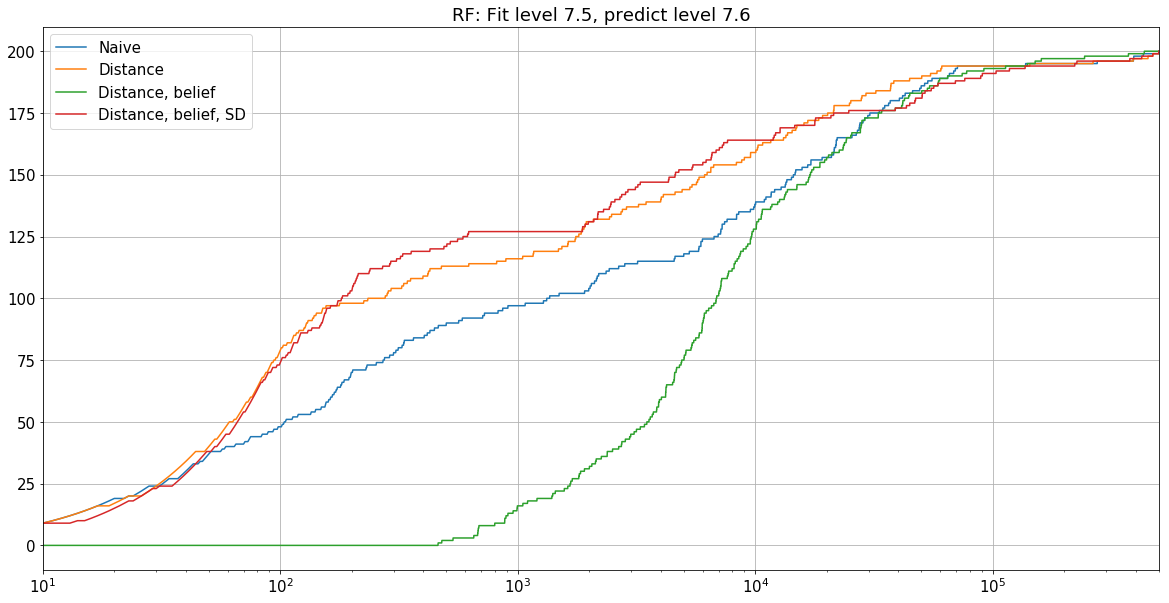

In [131]:
plt.title('RF: Fit level 7.5, predict level 7.6')
plot(run_experiment_full(test_method='basic')[0][::-1].cumsum(), label='Naive')
plot(run_experiment_full(test_method='beliefed_acc')[0][::-1].cumsum(), label='Distance')
plot(run_experiment_full(test_method='beliefed_fa')[0][::-1].cumsum(), label='Distance, belief')
plot(run_experiment_full()[0][::-1].cumsum(), label='Distance, belief, SD')
legend(loc='best')
plt.xscale('log')
grid(True)
_ = plt.xlim(10, 5e5)

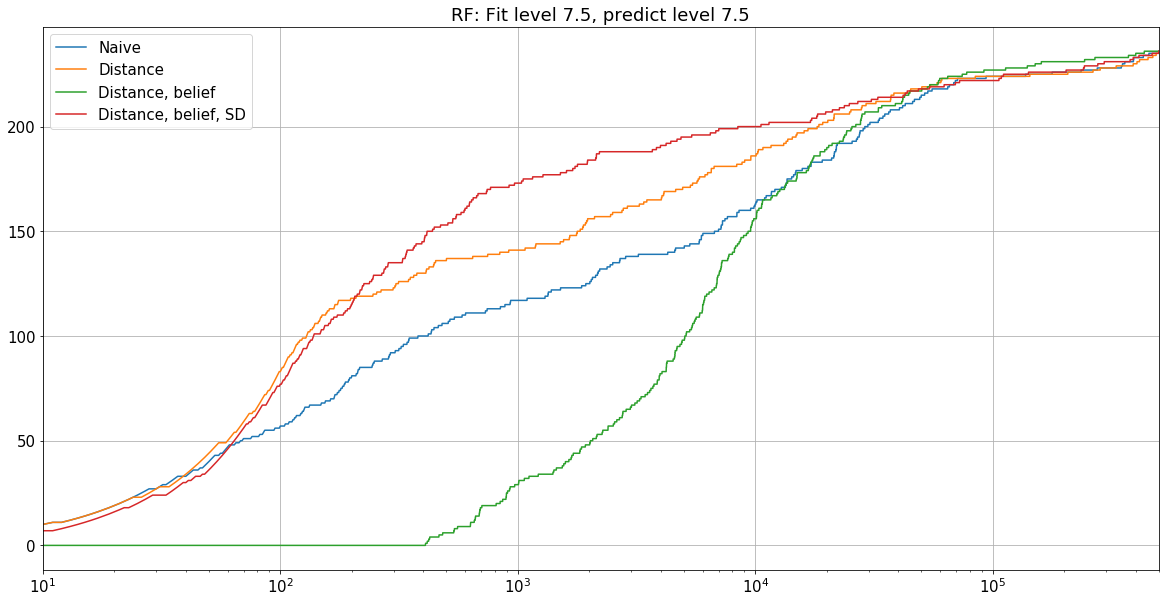

In [130]:
plt.title('RF: Fit level 7.5, predict level 7.5')
plot(run_experiment_full(test_method='basic',  level_predict=7.5)[0][::-1].cumsum(), label='Naive')
plot(run_experiment_full(test_method='beliefed_acc',  level_predict=7.5)[0][::-1].cumsum(), label='Distance')
plot(run_experiment_full(test_method='beliefed_fa',  level_predict=7.5)[0][::-1].cumsum(), label='Distance, belief')
plot(run_experiment_full(level_predict=7.5)[0][::-1].cumsum(), label='Distance, belief, SD')
legend(loc='best')
plt.xscale('log')
grid(True)
_ = plt.xlim(10, 5e5)

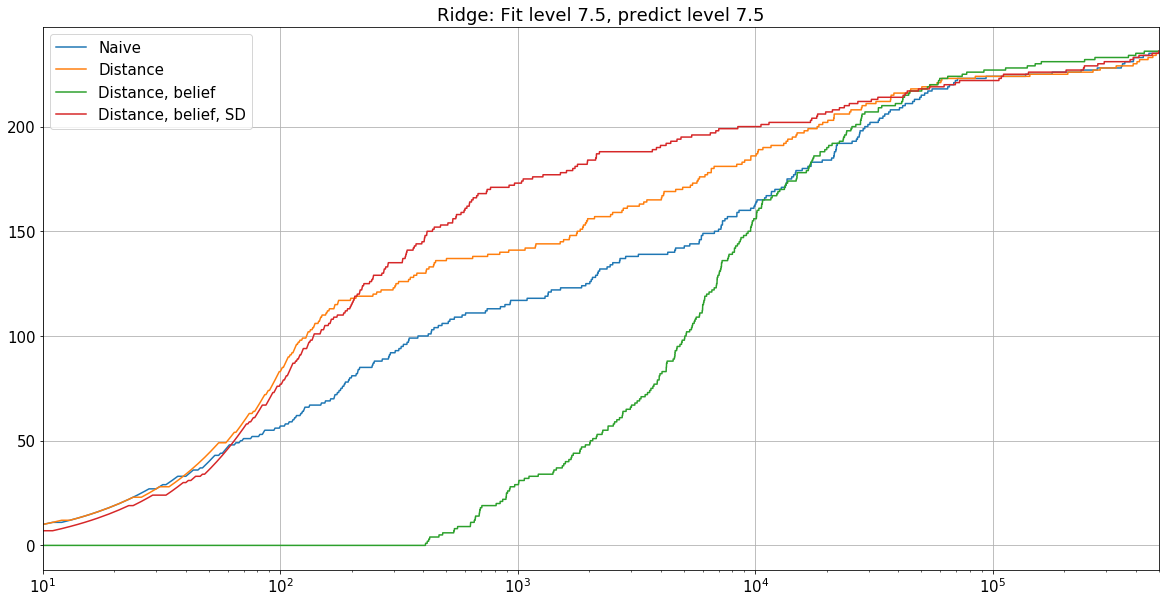

In [166]:
plt.title('Ridge: Fit level 7.5, predict level 7.5')
plot(run_experiment_full(test_method='basic',  level_predict=7.5, level_fit=7.5)[0][::-1].cumsum(), label='Naive')
plot(run_experiment_full(test_method='beliefed_acc',  level_predict=7.5, level_fit=7.5)[0][::-1].cumsum(), label='Distance')
plot(run_experiment_full(test_method='beliefed_fa',  level_predict=7.5, level_fit=7.5)[0][::-1].cumsum(), label='Distance, belief')
plot(run_experiment_full(level_predict=7.5, level_fit=7.5)[0][::-1].cumsum(), label='Distance, belief, SD')
legend(loc='best')
plt.xscale('log')
grid(True)
_ = plt.xlim(10, 5e5)

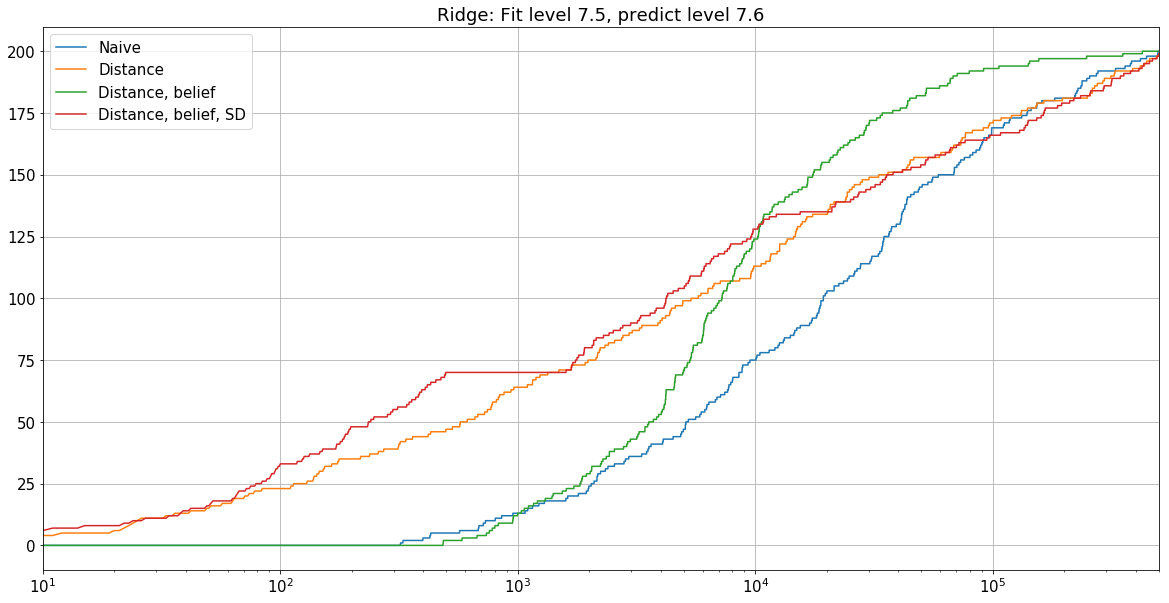

In [165]:
plt.title('Ridge: Fit level 7.5, predict level 7.6')
plot(run_experiment_full(test_method='basic', method='ridge')[0][::-1].cumsum(), label='Naive')
plot(run_experiment_full(test_method='beliefed_acc', method='ridge')[0][::-1].cumsum(), label='Distance')
plot(run_experiment_full(test_method='beliefed_fa', method='ridge')[0][::-1].cumsum(), label='Distance, belief')
plot(run_experiment_full(method='ridge')[0][::-1].cumsum(), label='Distance, belief, SD')
legend(loc='best')
plt.xscale('log')
grid(True)
_ = plt.xlim(10, 5e5)

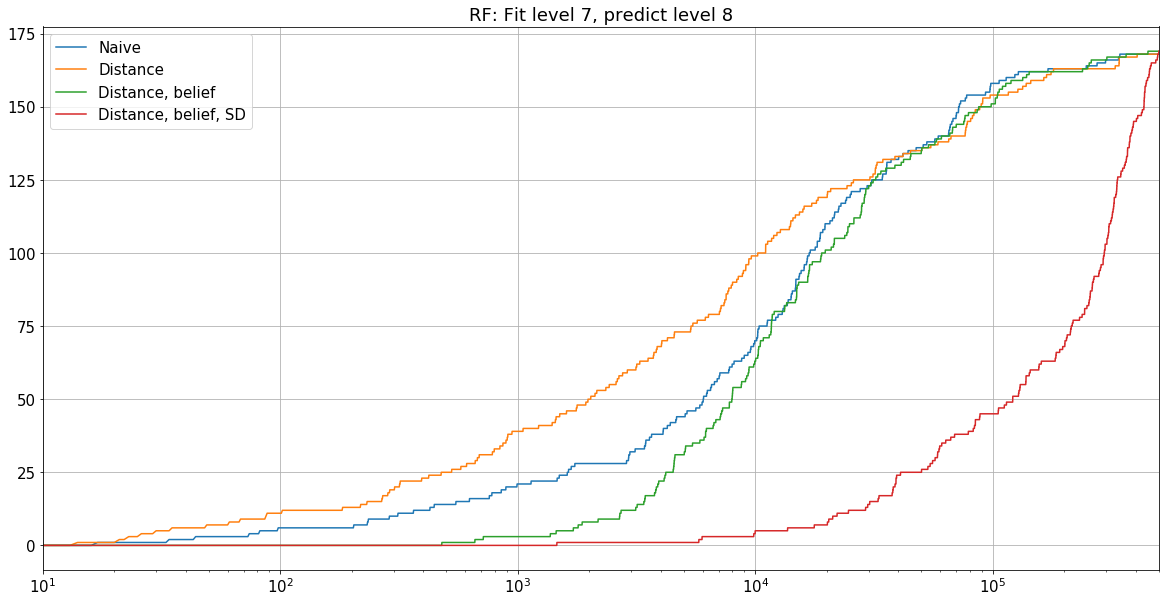

In [132]:
plt.title('RF: Fit level 7, predict level 8')
plot(run_experiment_full(test_method='basic',  level_predict=8, level_fit=7)[0][::-1].cumsum(), label='Naive')
plot(run_experiment_full(test_method='beliefed_acc',  level_predict=8, level_fit=7)[0][::-1].cumsum(), label='Distance')
plot(run_experiment_full(test_method='beliefed_fa',  level_predict=8, level_fit=7)[0][::-1].cumsum(), label='Distance, belief')
plot(run_experiment_full(level_predict=8, level_fit=7)[0][::-1].cumsum(), label='Distance, belief, SD')
legend(loc='best')
plt.xscale('log')
grid(True)
_ = plt.xlim(10, 5e5)

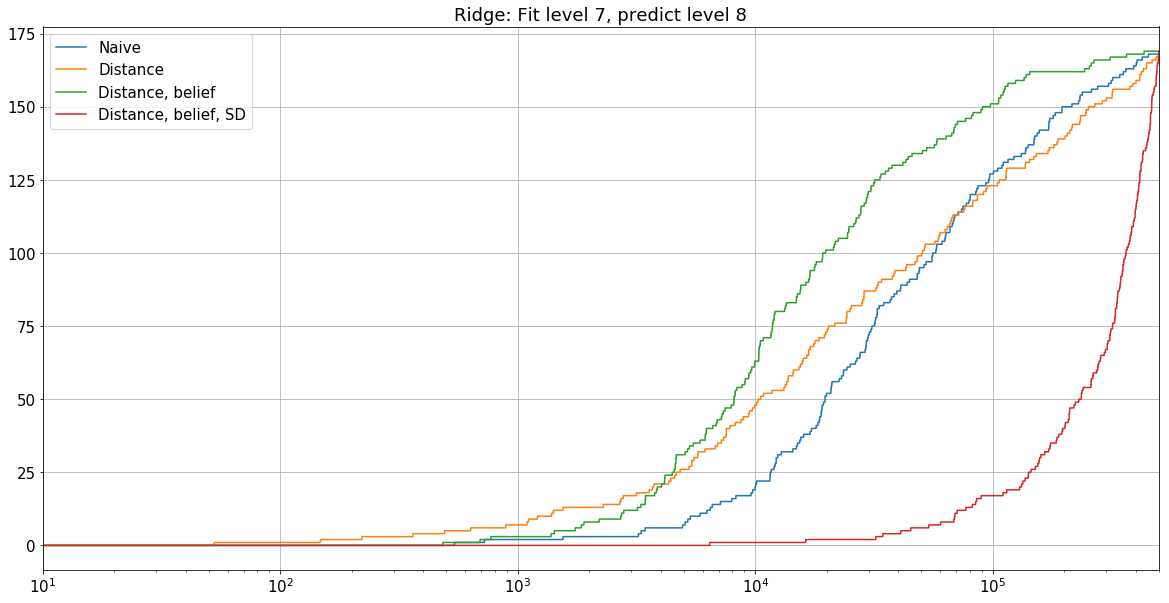

In [135]:
plt.title('Ridge: Fit level 7, predict level 8')
plot(run_experiment_full(test_method='basic',  level_predict=8, level_fit=7, method='ridge')[0][::-1].cumsum(), label='Naive')
plot(run_experiment_full(test_method='beliefed_acc',  level_predict=8, level_fit=7, method='ridge')[0][::-1].cumsum(), label='Distance')
plot(run_experiment_full(test_method='beliefed_fa',  level_predict=8, level_fit=7, method='ridge')[0][::-1].cumsum(), label='Distance, belief')
plot(run_experiment_full(level_predict=8, level_fit=7, method='ridge')[0][::-1].cumsum(), label='Distance, belief, SD')
legend(loc='best')
plt.xscale('log')
grid(True)
_ = plt.xlim(10, 5e5)